In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path

print(Path().cwd())
os.chdir(Path(os.getcwd()).parent)
print(Path().cwd())

/Users/samantha/QuantUS-Plugins-CEUS/TwoD_CEUS_test
/Users/samantha/QuantUS-Plugins-CEUS


## Select Contrast-Enhanced Ultrasound (CEUS) Cine and Parser

In [2]:
from src.image_loading.options import get_scan_loaders

print("Available scan loaders:", list(get_scan_loaders().keys()))

Available scan loaders: ['avi', 'nifti', 'custom_dicom', 'mp4']


In [3]:
scan_type = 'mp4'

scan_path = '/Users/samantha/Desktop/ultrasound lab stuff/mc_ctdna/p14/p14_wk24/p14_wk24.mp4'
scan_loader_kwargs = {
    'transpose': False
}

In [4]:
from src.entrypoints import scan_loading_step

image_data = scan_loading_step(scan_type, scan_path, **scan_loader_kwargs)

## Load Segmentation

Assumes same segmentation for each frame

In [5]:
from src.seg_loading.options import get_seg_loaders

print("Available segmentation loaders:", list(get_seg_loaders().keys()))

Available segmentation loaders: ['nifti', 'load_bolus_mask']


In [6]:
seg_type = 'nifti'

seg_path = '/Users/samantha/Desktop/ultrasound lab stuff/mc_ctdna/p14/p14_wk24/p14_wk24_mc_roi.nii.gz'
seg_loader_kwargs = {}

In [7]:
from src.entrypoints import seg_loading_step

seg_data = seg_loading_step(seg_type, image_data, seg_path, scan_path, **seg_loader_kwargs)

(np.float64(-0.5), np.float64(1961.5), np.float64(1471.5), np.float64(-0.5))

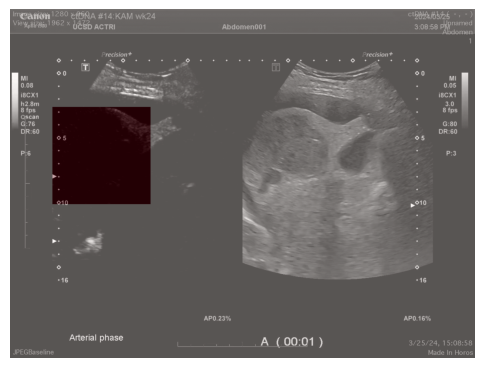

In [11]:
seg_mask = seg_data.seg_mask
frames = image_data.pixel_data[:,:,:,0]

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(frames[10], cmap='gray')
roi_mask = seg_mask[:,:,10].T
ax.imshow(roi_mask, alpha=0.35, cmap='Reds')
ax.axis('off')




In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

frames = image_data.pixel_data[:,:,:,0]
seg_mask = seg_data.seg_mask

print(f'Segmentation mask shape: {seg_mask.shape}')
print(f'Image data shape: {image_data.pixel_data.shape}')

frame_slider = widgets.IntSlider(
    value=50,
    min=0,
    max=frames.shape[0] - 1,
    step=1,
    description='Frame',
    continuous_update=False,
    layout=widgets.Layout(width='600px')
)

frame_input = widgets.BoundedIntText(
    value = 50,
    min = 0,
    max = frames.shape[0]-1,
    step = 1,
    description='',
    layout=widgets.Layout(width='80px')
)

overlay_toggle = widgets.ToggleButton(
    value=False,
    description='Show ROI',
    icon='eye',
)

output = widgets.Output()

def _select_seg_frame(frame_idx: int):
    if seg_mask.ndim == 3 and seg_mask.shape[2] == frames.shape[0]:
        return seg_mask[:,:,frame_idx].T
    return seg_mask


def _render_frame(change=None):
    with output:
        output.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(frames[frame_slider.value], cmap='gray')
        if overlay_toggle.value:
            roi_mask = _select_seg_frame(frame_slider.value)
            ax.imshow(roi_mask, alpha=0.35, cmap='Reds')
        ax.set_title(f"{seg_data.seg_name} - Frame {frame_slider.value}")
        ax.axis('off')
        plt.show()

def _sync_slider_to_input(change):
    frame_input.value = change['new']

def _sync_input_to_slider(change):
    frame_slider.value - change['new']

frame_slider.observe(_render_frame, names='value')
overlay_toggle.observe(_render_frame, names='value')

slider_row = widgets.HBox([frame_slider, overlay_toggle])
# control_row = widgets.HBox([frame_slider, overlay_toggle])
controls = widgets.VBox([slider_row])

display(controls, output)
_render_frame()


Segmentation mask shape: (1962, 1472, 833)
Image data shape: (833, 1472, 1962, 3)


Output()

# Generating T0 map using Segmentation Mask and Pixel data.

In [13]:
image_data.pixel_data.shape

(833, 1472, 1962, 3)

Analyzed ROI in frames 0-250:
  Mean: 75.74
  Median: 89.15
  Std: 25.85

Using median threshold: 89.15


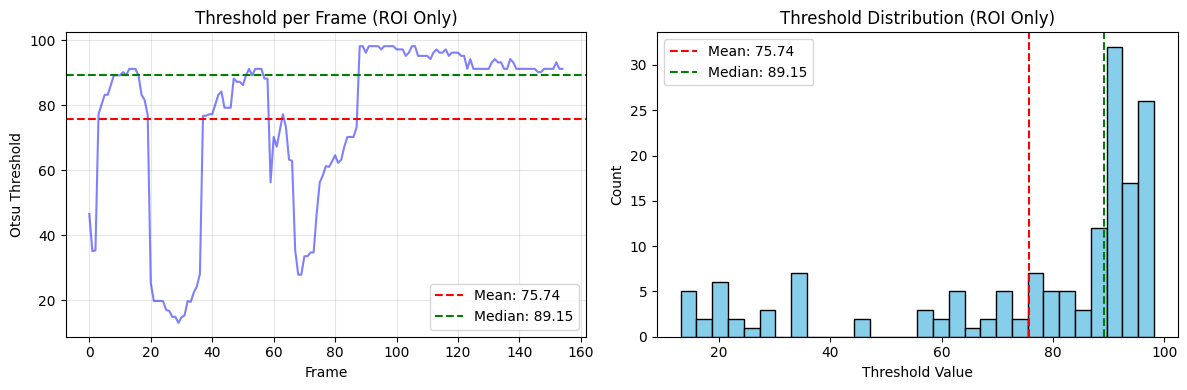

In [31]:
def otsu_threshold(frame_array, bins=256):
    values = frame_array[np.isfinite(frame_array)].astype(np.float32).ravel()
    if values.size == 0:
        raise ValueError("No valid pixels available for Otsu thresholding")
    hist, bin_edges = np.histogram(values, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    total = values.size
    sum_total = np.dot(hist, bin_centers)
    weight_background = 0.0
    sum_background = 0.0
    max_variance = 0.0
    threshold_value = float(bin_centers[0])
    for h, center in zip(hist, bin_centers):
        weight_background += h
        if weight_background == 0:
            continue
        weight_foreground = total - weight_background
        if weight_foreground == 0:
            break
        sum_background += h * center
        mean_background = sum_background / weight_background
        mean_foreground = (sum_total - sum_background) / weight_foreground
        between_variance = weight_background * weight_foreground * (mean_background - mean_foreground) ** 2
        if between_variance > max_variance:
            max_variance = between_variance
            threshold_value = center
    return threshold_value

# Compute Otsu across multiple frames, using ROI only
start_frame = 0
end_frame = 250
frames = image_data.pixel_data[:,:,:,0]
seg_mask = seg_data.seg_mask

thresholds = []
for i in range(start_frame, end_frame):
    frame = np.asarray(frames[i], dtype=np.float32)
    
    # Get mask for this frame
    if seg_mask.ndim == 3 and seg_mask.shape[2] == frames.shape[0]:
        roi_mask = seg_mask[:,:,i].T
    else:
        roi_mask = seg_mask
    
    # Extract only ROI pixels
    roi_pixels = frame[roi_mask > 0]
    
    if roi_pixels.size > 0:
        thresh = otsu_threshold(roi_pixels)
        thresholds.append(thresh)

thresholds = np.array(thresholds)

# Statistics
print(f"Analyzed ROI in frames {start_frame}-{end_frame}:")
print(f"  Mean: {thresholds.mean():.2f}")
print(f"  Median: {np.median(thresholds):.2f}")
print(f"  Std: {thresholds.std():.2f}")

# Use median as optimal threshold
otsu_threshold_value = np.median(thresholds)
print(f"\nUsing median threshold: {otsu_threshold_value:.2f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(range(start_frame, start_frame + len(thresholds)), thresholds, 'b-', alpha=0.5)
axes[0].axhline(thresholds.mean(), color='r', linestyle='--', label=f'Mean: {thresholds.mean():.2f}')
axes[0].axhline(np.median(thresholds), color='g', linestyle='--', label=f'Median: {np.median(thresholds):.2f}')
axes[0].set_xlabel('Frame')
axes[0].set_ylabel('Otsu Threshold')
axes[0].set_title('Threshold per Frame (ROI Only)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(thresholds, bins=30, color='skyblue', edgecolor='black')
axes[1].axvline(thresholds.mean(), color='r', linestyle='--', label=f'Mean: {thresholds.mean():.2f}')
axes[1].axvline(np.median(thresholds), color='g', linestyle='--', label=f'Median: {np.median(thresholds):.2f}')
axes[1].set_xlabel('Threshold Value')
axes[1].set_ylabel('Count')
axes[1].set_title('Threshold Distribution (ROI Only)')
axes[1].legend()

plt.tight_layout()
plt.show()

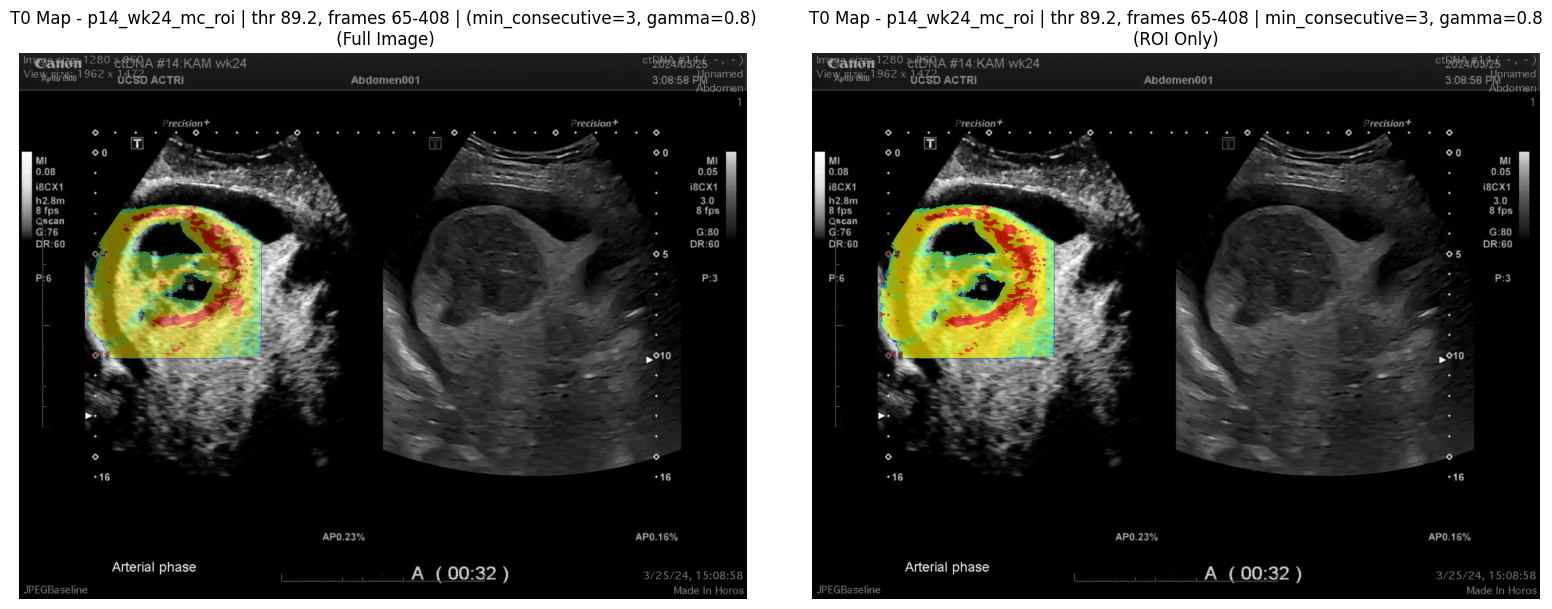


T0 Map Statistics:
  mean_t0: 235.99
  median_t0: 241.00
  std_t0: 35.28
  min_t0: 16.00
  max_t0: 334.00
  coverage: 75.36


In [45]:
from TwoD_CEUS_test.T0_map import generate_t0_map, get_t0_statistics, mask_t0_map

# Generate the T0 map with temporal consistency filtering
threshold = float(otsu_threshold_value)  # Computed via Otsu
start_frame = 65
end_frame = 408
min_consecutive_frames = 3  # Require 3 consecutive frames above threshold (filters noise)

t0_map = generate_t0_map(
    image_data.pixel_data[:,:,:,0],  # Use the first channel if multi-channel
    seg_data.seg_mask,
    threshold=threshold,
    start_frame=start_frame,
    end_frame=end_frame,
    min_consecutive_frames=min_consecutive_frames
)

# Mask the T0 map to show only ROI
masked_t0_map = mask_t0_map(t0_map, seg_data.seg_mask)

# Make pixels that never enhanced transparent (set to NaN)
t0_map_transparent = t0_map.copy().astype(float)
t0_map_transparent[t0_map == 0] = np.nan

masked_t0_map_transparent = masked_t0_map.copy().astype(float)
masked_t0_map_transparent[masked_t0_map == 0] = np.nan

# Visualize it
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gamma correction
use_gamma = True      # <--- toggle this to False to disable
gamma = 0.8

if use_gamma:
    t0_map_transparent = t0_map_transparent ** (1/gamma)
    masked_t0_map_transparent = masked_t0_map_transparent ** (1/gamma)

# Build title with optional gamma value
gamma_str = f", gamma={gamma}" if use_gamma else ""
title_base = f'T0 Map - {seg_data.seg_name} | thr {threshold:.1f}, frames {start_frame}-{end_frame}'

# Left: Original with full overlay
single_image = image_data.pixel_data[250,:,:,0]
axes[0].imshow(single_image, cmap='gray')
axes[0].imshow(t0_map_transparent, alpha=0.5, cmap='jet')
axes[0].set_title(f'{title_base} | (min_consecutive={min_consecutive_frames}{gamma_str})\n (Full Image)')
axes[0].axis('off')

# Right: Masked to show only ROI
axes[1].imshow(single_image, cmap='gray')
axes[1].imshow(masked_t0_map_transparent, alpha=0.7, cmap='jet')
axes[1].set_title(f'{title_base} | min_consecutive={min_consecutive_frames}{gamma_str}\n(ROI Only)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Get statistics
stats = get_t0_statistics(t0_map, seg_data.seg_mask)
print("\nT0 Map Statistics:")
for key, value in stats.items():
    print(f"  {key}: {value:.2f}")